In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
import pubchempy as pcp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from jcamp import jcamp_calc_xsec, jcamp_readfile

In [13]:
PATH = "jdx"
SMILES = []
spectra = []

In [14]:
def closest(myList, myNumber):
    #Find num in list closest to mynum, used in preprocess
    from bisect import bisect_left
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before
    
def process_file(filename):
    """Convert spectrum units to wavenumbers (x) and transmittance (y), and interpolate any missing coordinates, then return a list of transmitances"""
    #TODO: ask if nitrogen dilution matters at all
    #MIN: 450, MAX: 4914, increments of 2
    spectrum = jcamp_readfile(filename)
    try:
        jcamp_calc_xsec(spectrum, skip_nonquant = False)
    except:
        return(False)
    return(np.array(spectrum))
    #plt.plot()


def why_bad(filename):
    spectrum = jcamp_readfile(filename)
    try:
        jcamp_calc_xsec(spectrum, skip_nonquant = False)
        if(spectrum["state"] != "gas" and spectrum['state'] != "GAS"):
            return(spectrum["state"])
    except:
        return("Couldn't read file")
    pass

In [15]:
bad, reason_bad = 0, []
bad_spectra = []
for spectrafile in tqdm(os.listdir(PATH)):
    try:
        spectrum = process_file(PATH + "/" + spectrafile)
    except:
        bad += 1
        continue
    if (type(spectrum) != np.ndarray):
        reason_bad.append(why_bad(PATH + "/" + spectrafile))
        bad_spectra.append(spectrafile[:-7])
        continue
    #Get the smiles out of the mol using rdkit
    molfile = "mol/" + spectrafile[:-7] + ".mol"
    mol = Chem.MolFromMolFile(molfile)
    try:
        sm = Chem.MolToSmiles(mol)
    except:
        continue  
    
    if(sm != ""):
        spectra.append(spectrum)
        SMILES.append(sm)
spectra = np.array(spectra)

  6%|▌         | 998/16121 [00:04<00:57, 264.17it/s][17:18:36] WARNING: not removing hydrogen atom without neighbors
[17:18:36] WARNING: not removing hydrogen atom without neighbors
 11%|█         | 1717/16121 [00:06<00:51, 280.40it/s][17:18:39] WARNING: not removing hydrogen atom without neighbors
[17:18:39] Explicit valence for atom # 5 O, 4, is greater than permitted
 11%|█▏        | 1851/16121 [00:07<00:45, 317.02it/s][17:18:39] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[17:18:39] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
 32%|███▏      | 5107/16121 [00:18<00:33, 326.82it/s][17:18:51] Explicit valence for atom # 0 B, 6, is greater than permitted
[17:18:51] Explicit valence for atom # 1 B, 4, is greater than permitted
 66%|██████▋   | 10700/16121 [00:38<00:17, 302.76it/s][17:19:11] Explicit valence for atom # 14 N, 5, is greater than permitted
[17:19:11] Explicit valence for ato

In [16]:
print(bad, "files couldn't be processed at all.")
from collections import Counter
print(bad_spectra)
with open("bad_spectra.txt", "w") as f:
    for spectrum in bad_spectra:
        f.write(spectrum + "\n")
print(Counter(reason_bad))

0 files couldn't be processed at all.
['C77619933', 'C6851805', 'B6002214', 'C6380343', 'B6007708', 'B6004851', 'C19829722', 'B6003836', 'C501304', 'B6002369', 'C2545597', 'C3344192', 'C1570656', 'C39191076', 'C58855', 'C495692', 'B6009512', 'C5290620', 'C2576478', 'C93310919', 'C53133418', 'C1999855', 'B6002306', 'C74990491', 'C693072', 'C86711719', 'C122463', 'B6004107', 'C61709373', 'B6004007', 'C5284071', 'C116346237', 'C19438109', 'C53046847', 'C18773381', 'C2623338', 'C500721', 'C808480', 'C150254', 'C9003536', 'B6001237', 'C116401991', 'C33560542', 'C116435020', 'C6766569', 'C85836', 'B6004019', 'C82644', 'C103034715', 'C616728', 'B6009500', 'B6009251', 'C6077721', 'B6002549', 'B6002896', 'C4237370', 'C116402187', 'C116402461', 'C611927', 'C59039837', 'C51698772', 'C3732818', 'C74581945', 'C758101', 'B6003003', 'B6002265', 'C13908480', 'C10193983', 'C13463406', 'C2426871', 'C95817713', 'C38739741', 'C30542213', 'B6009279', 'C17374231', 'C90674445', 'C6436904', 'C76653', 'B600048

In [ ]:
datadict = {"SMILES": SMILES}
for i in range(2232):
    datadict[i] = []
for spectrum in spectra:
    print(spectrum)
    for i in range(2232):
dataset = pd.DataFrame(data = datadict)
dataset.to_csv("NIST Gaseous IR Dataset.csv")

{'title': 'Naphthalene, 1,5-dimethyl-', 'jcamp-dx': 4.24, 'data type': 'INFRARED SPECTRUM', 'origin': 'Sadtler Research Labs Under US-EPA Contract', 'owner': 'NIST Standard Reference Data Program\nCollection (C) 2018 copyright by the U.S. Secretary of Commerce\non behalf of the United States of America. All rights reserved.', 'cas registry no': '571-61-9', 'molform': 'C 12 H 12', '$nist source': 'MSDC-IR', 'state': 'gas', 'xunits': '1/CM', 'yunits': 'ABSORBANCE', 'xfactor': 1.0, 'yfactor': 0.000101785, 'deltax': 4.0, 'firstx': 450.0, 'lastx': 3966.0, 'firsty': 0.012621, 'maxx': 3966, 'minx': 450, 'maxy': 1.01785, 'miny': 0, 'npoints': 880, 'xydata': '(X++(Y..Y))', 'end': '', 'x': array([ 450.,  454.,  458.,  462.,  466.,  470.,  474.,  478.,  482.,
        486.,  490.,  494.,  498.,  502.,  506.,  510.,  514.,  518.,
        522.,  526.,  530.,  534.,  538.,  542.,  546.,  550.,  554.,
        558.,  562.,  566.,  570.,  574.,  578.,  582.,  586.,  590.,
        594.,  598.,  602.,  60

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

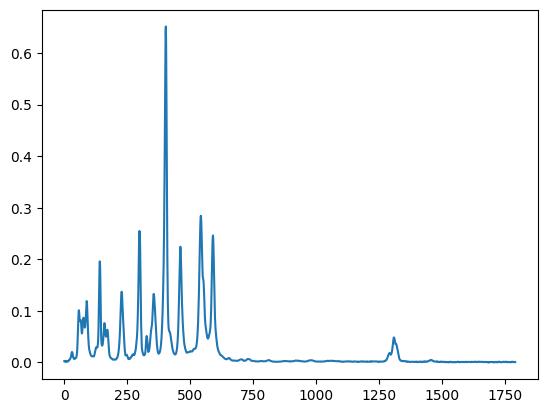

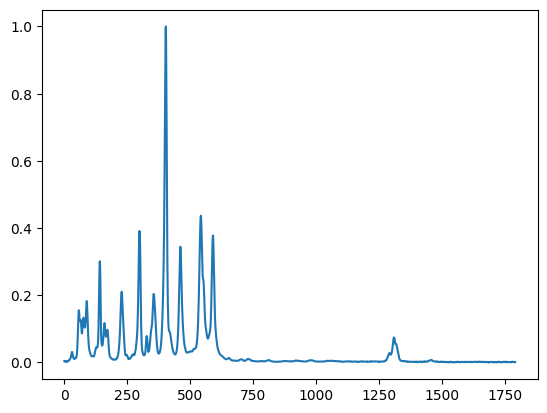

In [ ]:
def normalize(s):
    """Normalize the input series from 0->1 and return it"""
    maxval = max(s)
    scale = 1 / maxval
    return([j * scale for j in s])

tst = jcamp_readfile("jdx/1072-82-8-IR.jdx")
plt.plot(tst['y'])
plt.show()
plt.plot(normalize(tst['y']))
plt.show()